# Tom Segal's Entry For the Competition "SIIM-ISIC Melanoma Classification" ##

This is my third ML project.

The first project was the MNIST digit recognizer, 10 labels for 1-color images.

The second project was flower identification, >100 labels for 3-color images.

In this project tumors are differiented into malignant (melanoma-inducing) and benign.

In this project, downsampling is used in order to even the label distribution. An unconventional loss function, Focal Loss, is used in order to compensate for the remaining difference in the distribution.

Project overview https://www.kaggle.com/c/siim-isic-melanoma-classification

data https://www.kaggle.com/c/siim-isic-melanoma-classification/data



this project relies on research of the following notebooks:

https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords

https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155579

https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once

https://www.kaggle.com/ibtesama/siim-baseline-keras-vgg16


additional references:

https://pypi.org/project/focal-loss/


I acknowledge and appreciate the support of the kaggle community.


In [1]:
!pip install focal-loss

     |████████████████████████████████| 6.8 MB 6.5 MB/s eta 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pytorch-lightning 0.9.0 requires tensorboard==2.2.0, but you'll have tensorboard 2.3.0 which is incompatible.


## install missing libraries ##

In [2]:
import tensorflow as tf
print("tensorflow version: " + tf.__version__)
from kaggle_datasets import KaggleDatasets
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications import DenseNet201
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.python.keras import backend
from focal_loss import BinaryFocalLoss

tensorflow version: 2.3.0


## define constants ##

In [3]:
random_state = 19 # using a constant random seed makes the results more consistent and helps comparing between them.

## read the data as panda dataframe for examination ##

In [4]:
# Get the path of the Current System (GCS)
GCS_PATH = KaggleDatasets().get_gcs_path("siim-isic-melanoma-classification")
# get the train data in dataframe format for quick examination of the data
dataframe_train = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")


## examine the data ##

view the first few dataframe entries

In [5]:
dataframe_train.head(10)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0
7,ISIC_0075663,IP_6017204,female,35.0,torso,unknown,benign,0
8,ISIC_0075914,IP_7622888,male,30.0,torso,unknown,benign,0
9,ISIC_0076262,IP_5075533,female,50.0,lower extremity,unknown,benign,0


plot some samples

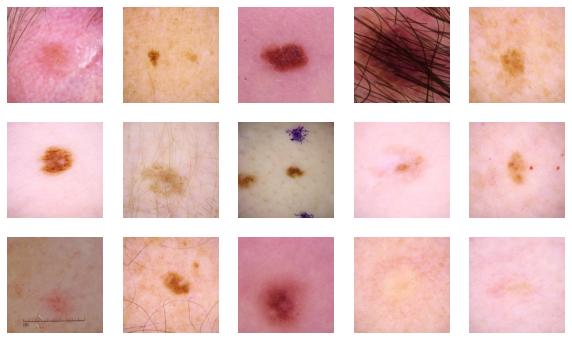

In [6]:
# image_paths = GCS_PATH_TRAIN + "\\" + dataframe_train["image_name"]+".jpg" # \\ because \ is an escape character
# image_paths = "../input/siim-isic-melanoma-classification/jpeg/train/" + dataframe_train["image_name"] + ".jpg" 
image_paths = "../input/jpeg-melanoma-256x256/train/" + dataframe_train["image_name"] + ".jpg" 
f, ax = plt.subplots(3, 5, figsize = (10,6))
for i in range(15):
    #print(image_paths[i])
    img = cv2.imread(image_paths[i])
    #print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # the default cv2 format is BGR
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis("off")
plt.show()
    

examine the label distribution

In [7]:
dataframe_train["target"].value_counts()

0    32542
1      584
Name: target, dtype: int64

584/32542 = ~1.8% of the tumors are malignant, such that the labels are highly unbalanced.

this can be treated using oversampling or undersampling.

## undersampling ##

only a portion of the benign tumor training data will be used in order to make the labels more balanced.

In [8]:
downsampling = 1000
# sample 1000 benign samples and merge them together with all of the malignant samples
dataframe_train_benign_downsampled = dataframe_train[dataframe_train["target"]==0].sample(downsampling)
dataframe_train_malignant = dataframe_train[dataframe_train["target"]==1]
# join the two parts together. Note that now the two sample types are not mixed anymore in the data
# but appear in two blocks.
dataframe_train_downsampled = pd.concat([dataframe_train_benign_downsampled, dataframe_train_malignant])

show benign tumor samples

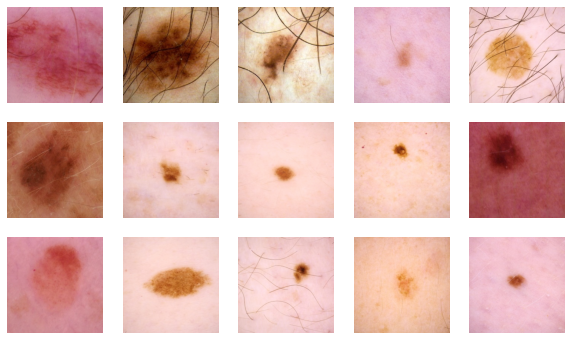

In [9]:
image_paths = ["../input/jpeg-melanoma-256x256/train/" + dataframe_train_benign_downsampled["image_name"].values[i] + ".jpg" for i in range(downsampling)]
f, ax = plt.subplots(3, 5, figsize = (10,6))
for i in range(15):
    #print(image_paths[i])
    img = cv2.imread(image_paths[i])
    #print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # the default cv2 format is BGR

    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis("off")
plt.show()

show malignant tumor samples

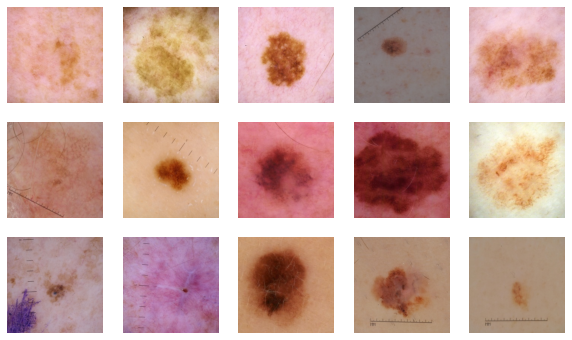

In [10]:
image_paths = ["../input/jpeg-melanoma-256x256/train/" + dataframe_train_malignant["image_name"].values[i] + ".jpg" for i in range(dataframe_train_malignant.shape[0])]

#print(image_paths[1])
f, ax = plt.subplots(3, 5, figsize = (10,6))
for i in range(15):
    #print(image_paths[i])
    img = cv2.imread(image_paths[i])
    #print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # the default cv2 format is BGR
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis("off")
plt.show()

## simplify the data  ##

create datasets with only the images and the labels

In [11]:
image_paths = ["../input/jpeg-melanoma-256x256/train/" + dataframe_train_benign_downsampled["image_name"].values[i] + ".jpg" for i in range(downsampling)]


In [12]:
dataframe_train_labels = []
dataframe_train_images = []
for i in range(dataframe_train_downsampled.shape[0]):
    dataframe_train_labels.append(dataframe_train_downsampled["target"].values[i])
    dataframe_train_images.append("../input/jpeg-melanoma-256x256/train/" + dataframe_train_downsampled["image_name"].values[i] + ".jpg")
    
# create a dataframe from the columns
nparray_train_reduced_tuples = zip(dataframe_train_images, dataframe_train_labels)
# dataframe_train_reduced = pd.DataFrame(np.array([dataframe_train_labels, dataframe_train_images]), columns = ["label","image"])
dataframe_train_reduced = pd.DataFrame(nparray_train_reduced_tuples, columns = ["image","label"])
# dataframe_train_reduced = pd.DataFrame(np.array([dataframe_train_labels, dataframe_train_images]))
dataframe_train_reduced.head()

,image,label
0,../input/jpeg-melanoma-256x256/train/ISIC_7033...,0
1,../input/jpeg-melanoma-256x256/train/ISIC_3309...,0
2,../input/jpeg-melanoma-256x256/train/ISIC_2500...,0
3,../input/jpeg-melanoma-256x256/train/ISIC_4474...,0
4,../input/jpeg-melanoma-256x256/train/ISIC_4885...,0


## split the data into train and validation ##

In [13]:
x_train, x_val, y_train, y_val = train_test_split(dataframe_train_reduced["image"], dataframe_train_reduced["label"],
                                                 test_size = 0.2, random_state = random_state)
dataframe_train_split = pd.DataFrame(zip(x_train,y_train), columns = ["image","label"])
dataframe_val = pd.DataFrame(zip(x_val,y_val), columns = ["image","label"])

## data normaliztion & augmentation ##

In [14]:
gen_train = ImageDataGenerator(
    rescale = 1./255, # rescale the images (RGB [0,255])
    width_shift_range = 0.15, height_shift_range = 0.15, # randomly shift the pictures by 15% in both axes
    horizontal_flip = True, vertical_flip = True, # randomly flip the images in both axes
)
train_generator = gen_train.flow_from_dataframe(dataframe_train_reduced, x_col = "image", y_col = "label",
                                               target_size = (256,256), batch_size = 8,
                                               shuffle = True, # important as mentioned above
                                               class_mode = "raw")
val_generator = gen_train.flow_from_dataframe(dataframe_val, x_col = "image", y_col = "label",
                                               target_size = (256,256), batch_size = 8,
                                               shuffle = True, # not sure if important
                                               class_mode = "raw")


Found 1584 validated image filenames.
Found 317 validated image filenames.


## define the model ##

for the model a pretrained VGG16 model will be used, pre-weighted on "imagenet", with a flatten and a dense model placed on top.



In [15]:
model = VGG16(weights = "imagenet",
             include_top = False, # because a new top will be added to match the dimensions of this dataset
             input_shape = (256,256,3))
x = Flatten()(model.output)
output = Dense(1,activation = "sigmoid")(x)
model = Model(model.input, output)



58892288/58889256 [==============================] - 1s 0us/step


## compile the model ##

In [16]:
model.compile(loss = "binary_crossentropy", metrics = [tf.keras.metrics.AUC()], optimizer = Adam(lr=0.00001))

## train the model ##

batch_size = 8
steps_per_epoch = dataframe_train_reduced.shape[0] // batch_size
epochs = 3
validation_steps = dataframe_val.shape[0] // batch_size
history = model.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = epochs,
                    validation_data = val_generator, validation_steps = validation_steps)

## results ##

Epoch 1/3
198/198 [==============================] - 2103s 11s/step - loss: 0.5735 - auc_1: 0.7306 - val_loss: 0.5575 - val_auc_1: 0.8149
Epoch 2/3
198/198 [==============================] - 2106s 11s/step - loss: 0.5137 - auc_1: 0.8001 - val_loss: 0.4799 - val_auc_1: 0.8388
Epoch 3/3
198/198 [==============================] - 2104s 11s/step - loss: 0.4836 - auc_1: 0.8234 - val_loss: 0.4836 - val_auc_1: 0.8667

## using focal loss instead of crossentropy ##

https://arxiv.org/abs/1708.02002

"We propose to address this class imbalance by reshaping the standard cross entropy loss such that it down-weights the loss assigned to well-classified examples. Our novel Focal Loss focuses training on a sparse set of hard examples and prevents the vast number of easy negatives from overwhelming the detector during training."

In [17]:
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = backend.binary_crossentropy(y_true, y_pred)
        
        y_pred = backend.clip(y_pred, backend.epsilon(), 1.- backend.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = backend.pow((1-p_t), gamma)

        # compute the final loss and return
        return backend.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [18]:
model.compile(loss=BinaryFocalLoss(gamma=2), metrics = [tf.keras.metrics.AUC()], optimizer = Adam(lr=0.00001))

batch_size = 8
steps_per_epoch = dataframe_train_reduced.shape[0] // batch_size
epochs = 3
validation_steps = dataframe_val.shape[0] // batch_size
history2 = model.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = epochs,
                    validation_data = val_generator, validation_steps = validation_steps)

## results ##

Epoch 1/3
198/198 [==============================] - 2109s 11s/step - loss: 0.1244 - auc_6: 0.8345 - val_loss: 0.0998 - val_auc_6: 0.8968
Epoch 2/3
198/198 [==============================] - 2109s 11s/step - loss: 0.1140 - auc_6: 0.8596 - val_loss: 0.1055 - val_auc_6: 0.8924
Epoch 3/3
198/198 [==============================] - 2113s 11s/step - loss: 0.1112 - auc_6: 0.8663 - val_loss: 0.1087 - val_auc_6: 0.8911

better than with the crossentropy loss metric

## using DenseNet201 instead of VGG16 ##

In [19]:
model2 = DenseNet201(weights = "imagenet",
             include_top = False, # because a new top will be added to match the dimensions of this dataset
             input_shape = (256,256,3))
x = Flatten()(model2.output)
output = Dense(1,activation = "sigmoid")(x)
model2 = Model(model2.input, output)



74842112/74836368 [==============================] - 1s 0us/step


In [20]:
model2.compile(loss=BinaryFocalLoss(gamma=2), metrics = [tf.keras.metrics.AUC()], optimizer = Adam(lr=0.00001))

In [21]:
batch_size = 8
steps_per_epoch = dataframe_train_reduced.shape[0] // batch_size
epochs = 3
validation_steps = dataframe_val.shape[0] // batch_size
history3 = model2.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = epochs,
                    validation_data = val_generator, validation_steps = validation_steps)

Epoch 1/3
198/198 [==============================] - 1194s 6s/step - loss: 0.2557 - auc_2: 0.6912 - val_loss: 0.2462 - val_auc_2: 0.6968
Epoch 2/3
198/198 [==============================] - 1223s 6s/step - loss: 0.2170 - auc_2: 0.7629 - val_loss: 0.1782 - val_auc_2: 0.8301
Epoch 3/3
198/198 [==============================] - 1197s 6s/step - loss: 0.1912 - auc_2: 0.8044 - val_loss: 0.1833 - val_auc_2: 0.8421


## results ##

almost twice as fast.

Epoch 1/3
198/198 [==============================] - 1194s 6s/step - loss: 0.2557 - auc_2: 0.6912 - val_loss: 0.2462 - val_auc_2: 0.6968
Epoch 2/3
198/198 [==============================] - 1223s 6s/step - loss: 0.2170 - auc_2: 0.7629 - val_loss: 0.1782 - val_auc_2: 0.8301
Epoch 3/3
198/198 [==============================] - 1197s 6s/step - loss: 0.1912 - auc_2: 0.8044 - val_loss: 0.1833 - val_auc_2: 0.8421

## results summary ##

so far the best result is that of VGG16 with focal loss


## submit the results ##

In [26]:
predictions = [] # the test predictions will be stored here
# read the test csv file and obtain the image paths from it
dataframe_test = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")
test_image_paths = ["../input/jpeg-melanoma-256x256/test/" + image_name + ".jpg" for image_name in dataframe_test["image_name"]]
print(test_image_paths[5])

../input/jpeg-melanoma-256x256/test/ISIC_0074618.jpg


In [31]:
predictions = [] # the test predictions will be stored here
# read the test csv file and obtain the image paths from it
dataframe_test = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")
test_image_paths = ["../input/jpeg-melanoma-256x256/test/" + image_name + ".jpg" for image_name in dataframe_test["image_name"]]
# go over the image paths, load their respective images, make a prediction for them and save the predictions
i=0
for test_image_path in test_image_paths:
    img = cv2.imread(test_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.reshape(img,(1,256,256,3))
    predictions.append(model.predict(img))
    if i%100 == 0:
        print("finished " + str(i) + " out of " + str(len(test_image_paths)))
    i += 1



finished 1 out of 10982
finished 101 out of 10982
finished 201 out of 10982
finished 301 out of 10982
finished 401 out of 10982
finished 501 out of 10982
finished 601 out of 10982
finished 701 out of 10982
finished 801 out of 10982
finished 901 out of 10982
finished 1001 out of 10982
finished 1101 out of 10982
finished 1201 out of 10982
finished 1301 out of 10982
finished 1401 out of 10982
finished 1501 out of 10982
finished 1601 out of 10982
finished 1701 out of 10982
finished 1801 out of 10982
finished 1901 out of 10982
finished 2001 out of 10982
finished 2101 out of 10982
finished 2201 out of 10982
finished 2301 out of 10982
finished 2401 out of 10982
finished 2501 out of 10982
finished 2601 out of 10982
finished 2701 out of 10982
finished 2801 out of 10982
finished 2901 out of 10982
finished 3001 out of 10982
finished 3101 out of 10982
finished 3201 out of 10982
finished 3301 out of 10982
finished 3401 out of 10982
finished 3501 out of 10982
finished 3601 out of 10982
finished 3701

NameError: name 'submission' is not defined

In [33]:
submission = pd.read_csv("../input/siim-isic-melanoma-classification/sample_submission.csv")
submission["target"] = predictions
submission.to_csv("submission.csv", index = False)

submission.head(30)

AttributeError: 'DataFrame' object has no attribute '_to_csv'